# Unemployment based on different unemployment insurance funds in Denmark


Imports and set magics:

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# Our written modules
import dataproject as dp


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

In this project, we analyze unemployment data in Denmark, focusing on different unemployment insurance funds (A-kasser) to understand their impact on unemployment rates. The dataset, which we sourced from the Danish Statistics API (DstApi), contains information on full-time unemployment by area, benefit type, unemployment insurance fund, age, and gender.

The primary goal of this project is to investigate the unemployment trends across various unemployment insurance funds in Denmark. We aim to clean and process the data to extract meaningful insights, visualize the unemployment trends, and analyze the role of different unemployment insurance funds.

# Read and clean data

First off, we want to import the Api we should use. 

In [28]:
from dstapi import DstApi

We can now take our desired table, AUL01. This table contains data of full-time unemployed by area, benefit type, unemployment insurance fund, age and gender.

In [29]:
unemp = DstApi('AUL01') 

## Steps of the data cleaning

### Step 1: Define Parameters
We start by defining the parameters for the data we want to fetch, specifying the table, format, language, and variables of interest.

We therefore define a param dictionary. 

We would like to look at the unemployment insurance funds (A-kasse) and their unemployment amount. We are not interest in data specifiyng the sex, age and area. 
We use the variable "ydelsestype" but only want to look at Gross unemployment (TOT). So for the variables "YDELSESTYPE', 'ALDER' and 'KØN' we use the total amount (TOT) and for the area we use '000' which specifies 'All Denmark'.

In [30]:
params = dp.define_params()

### Step 2: Fetch Data
Using the defined parameters from step 1, we fetch the data from the dst unemployment database using the api.


In [31]:
unemp_data = dp.fetch_data(unemp, params)

### Step 3: Drop Unnecessary Columns
We clean the data by dropping columns that do not add valuable information to our analysis, as described in step 1.

In [32]:
columns_to_drop = ['YDELSESTYPE', 'ALDER', 'KØN']
unemp_data = dp.drop_columns(unemp_data, columns_to_drop)

### Step 4: Get insight on the unique Unemployment Insurance Funds
We identify the unique unemployment insurance funds present in our dataset. This way, we can get an overview of the different Insurance funds, which we later in the analysis will categorize.

In [33]:
unique_akasse = dp.get_unique_akasse(unemp_data)
print(unique_akasse)

['Akademikere (AAK) (- juni 2013)' 'Blik- og rør (-dec. 2007)'
 'Business ( - dec. 2014)' 'Børne- og Ungdomspædagoger (BUPL-A)'
 'Din Sundhedsfaglige A-kasse (DSA)' 'El-faget (- dec. 2020)'
 'A-kassen Frie (fra 1. januar 2020 inkl. DANA)'
 'Funktionærer og Servicefag ( - dec. 2016)'
 'Funktionærer og Tjenestemænd (FTF-A)'
 'Handels- og Kontorfunktionærer (HK)' 'Ingeniører (IAK) (- juni 2013)'
 'IT-faget og Merkonomer (PROSA) (-juni 2010)' 'Kristelig a-kasse'
 'Ledere' 'Lærere (DLF-A)' 'Magistre (MA)' 'Metalarbejdere'
 'Fødevareforbundet (NNF)' 'Selvstændige (DANA) (- dec. 2019)'
 'Selvstændige Erhvervsdrivende (ASE)' 'Socialpædagoger (SLA)'
 'Stats- og Teleansatte (STA) (-juni 2010)' 'Teknikere'
 'Træ-Industri-Byg (TIB) ( - dec. 2010)' 'Økonomer (CA)'
 'Det Faglige Hus A-kasse' 'Journalistik, Kommunikation og Sprog'
 'Malerfaget og Maritime (- dec. 2007)' 'Faglig Fælles a-kasse (3F)'
 'Fag og Arbejde (FOA)' 'Ikke forsikrede' 'Total'
 'Din Faglige A-kasse (fra 1. januar 2021 inkl. Bygge

### Step 5: Analyze Unemployment Over the Years
Before diving into the actual analysis, we analyze the total unemployment in Denmark over the years to understand the overall trend.

In [34]:
unemployment_year = dp.analyze_unemployment(unemp_data)
print(unemployment_year)

      TID  INDHOLD
31   2007   101409
62   2008    73152
93   2009   130237
123  2010   163531
152  2011   159264
181  2012   161245
209  2013   153129
237  2014   133282
264  2015   122561
291  2016   112524
317  2017   116175
343  2018   108001
369  2019   103997
394  2020   131347
418  2021   105798
442  2022    75544
466  2023    83323


## Analysis

To get a better overview of the unemployment over the years, described in step 5 in the data cleaning process, we plot the change of unemployemnt in a graph.

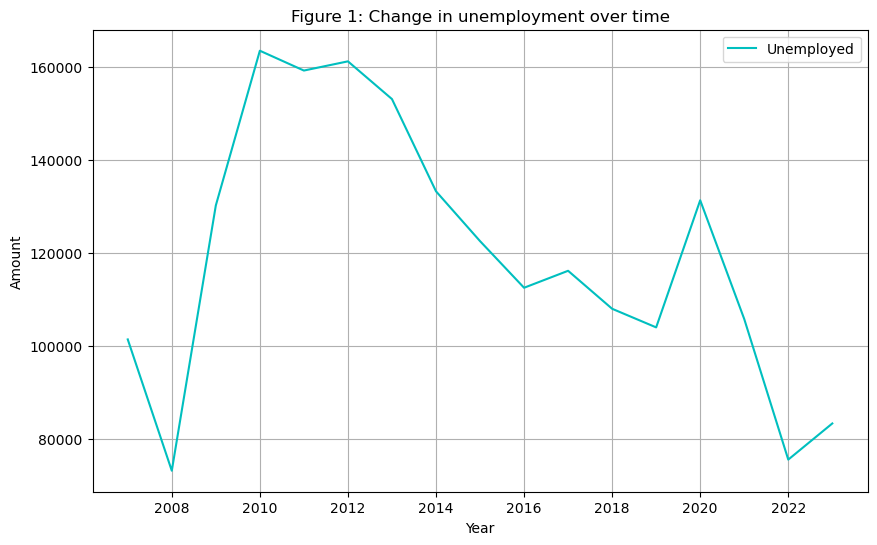

In [35]:
# We now plot the change in unemployment over time
plt.figure(figsize=(10,6))
plt.plot(unemployment_year['TID'], unemployment_year['INDHOLD'], color='c', label='Unemployed')
plt.grid(True)
plt.title('Figure 1: Change in unemployment over time')
plt.xlabel('Year')
plt.ylabel('Amount')
plt.legend()
plt.show()

As seen in figure 1, the overall unemployment changes a lot over the time period. 
From 2007 to 2022, Denmark experienced fluctuations in unemployment reflecting economic cycles. The global financial crisis of 2008 triggered a recession, causing unemployment to rise. It is important to note that we do not show the unemployment rate, but the actual amount of unemployed people. Denmark's proactive labor market policies helped mitigate the impact. Later economic recoveries led to periods of low unemployment, particularly during the boom years of the early 2010s. It is seen in figure 1 that the unemployment increased because of the CORONA virus, but at the end of the period it decreased to a level close to the start of the period. 

We now want to take a closer look on how different unemployment insurance funds influence the overall change in unemployment over the period. Before we can do this, we need to drop the A-kasse called 'TOTAL'. We will then use the split-apply-combine functions, to calculate each A-kasses share of total uneployment each year. 

In [36]:
# We find the indices where 'AKASSE' is 'Total'
indices = unemp_data[unemp_data['AKASSE'] == 'Total'].index

# We then drop these indices 
unemp_data.drop(indices, inplace=True)

# We now calculate the total 'INDHOLD' for each year
total_per_year = unemp_data.groupby('TID')['INDHOLD'].transform('sum')

# Then we group by 'Year' and 'AKASSE' and calculate the sum of 'INDHOLD' for each group
grouped_sum = unemp_data.groupby(['TID', 'AKASSE'])['INDHOLD'].transform('sum')

# Here we calculate the share of 'INDHOLD' for each 'AKASSE' relative to the total 'INDHOLD' for each year
unemp_data['Share in pct.'] = (grouped_sum / total_per_year)*100

# At last we show the results
unemp_data.head(5)

,OMRÅDE,AKASSE,TID,INDHOLD,Share in pct.
0,All Denmark,Akademikere (AAK) (- juni 2013),2007,2735,2.696973
1,All Denmark,Blik- og rør (-dec. 2007),2007,106,0.104526
2,All Denmark,Business ( - dec. 2014),2007,632,0.623213
3,All Denmark,Børne- og Ungdomspædagoger (BUPL-A),2007,1994,1.966276
4,All Denmark,Din Sundhedsfaglige A-kasse (DSA),2007,466,0.459521


As there are many observations in the table above, we would like to group the A-kasser in groups based on their professions. 

In [37]:
# We start off by defining dictionaries for the categories
categories = {
    "Byggeri, håndværk og industri": ["Blik- og rør (-dec. 2007)", "El-faget (- dec. 2020)", "Træ-Industri-Byg (TIB) ( - dec. 2010)", "Metalarbejdere", "Malerfaget og Maritime (- dec. 2007)"],
    "Sundhedspleje og socialt arbejde": ["Børne- og Ungdomspædagoger (BUPL-A)", "Din Sundhedsfaglige A-kasse (DSA)", "Fødevareforbundet (NNF)", "Socialpædagoger (SLA)", "Lærere (DLF-A)"],
    "Handel og service": ["Handels- og Kontorfunktionærer (HK)", "Ledere", "Funktionærer og Tjenestemænd (FTF-A)", "Funktionærer og Servicefag ( - dec. 2016)", "Journalistik, Kommunikation og Sprog"],
    "Teknologi og ingeniørvirksomhed": ["Ingeniører (IAK) (- juni 2013)", "IT-faget og Merkonomer (PROSA) (-juni 2010)", "Teknikere"],
    "Finanssektor og administration": ["Business ( - dec. 2014)","Økonomer (CA)", "Stats- og Teleansatte (STA) (-juni 2010)", "Kristelig a-kasse", "Det Faglige Hus A-kasse", "Akademikernes (fra 1. juli 2013 inkl. ingeniører)"],
    "Akademiske professioner": ["Akademikere (AAK) (- juni 2013)", "Magistre (MA)", "Min akasse ( - dec. 2014)", "Min akasse (jan. 2017 - inkl. Funktionærer og Servicefag)", "Din Faglige A-kasse (fra 1. januar 2021 inkl. Byggefagenes a-kasse og El-faget)", "Selvstændige (DANA) (- dec. 2019)", "Selvstændige Erhvervsdrivende (ASE)", "A-kassen Frie (fra 1. januar 2020 inkl. DANA)", "Faglig Fælles a-kasse (3F)", "Fag og Arbejde (FOA)"],
    "Ikke forsikrede": ["Ikke forsikrede"]
}

# We then create a new column for the category and iterate through the dictionary to assign categories
unemp_data['Category'] = None
for category, values in categories.items():
    unemp_data.loc[unemp_data['AKASSE'].isin(values), 'Category'] = category

# We now check if we got the right results
unemp_data.head(10)


,OMRÅDE,AKASSE,TID,INDHOLD,Share in pct.,Category
0,All Denmark,Akademikere (AAK) (- juni 2013),2007,2735,2.696973,Akademiske professioner
1,All Denmark,Blik- og rør (-dec. 2007),2007,106,0.104526,"Byggeri, håndværk og industri"
2,All Denmark,Business ( - dec. 2014),2007,632,0.623213,Finanssektor og administration
3,All Denmark,Børne- og Ungdomspædagoger (BUPL-A),2007,1994,1.966276,Sundhedspleje og socialt arbejde
4,All Denmark,Din Sundhedsfaglige A-kasse (DSA),2007,466,0.459521,Sundhedspleje og socialt arbejde
5,All Denmark,El-faget (- dec. 2020),2007,142,0.140026,"Byggeri, håndværk og industri"
6,All Denmark,A-kassen Frie (fra 1. januar 2020 inkl. DANA),2007,615,0.606449,Akademiske professioner
7,All Denmark,Funktionærer og Servicefag ( - dec. 2016),2007,717,0.707031,Handel og service
8,All Denmark,Funktionærer og Tjenestemænd (FTF-A),2007,3914,3.859580,Handel og service
9,All Denmark,Handels- og Kontorfunktionærer (HK),2007,11374,11.215856,Handel og service


Now we show the change in share of total unemployment for each category in a figure. 

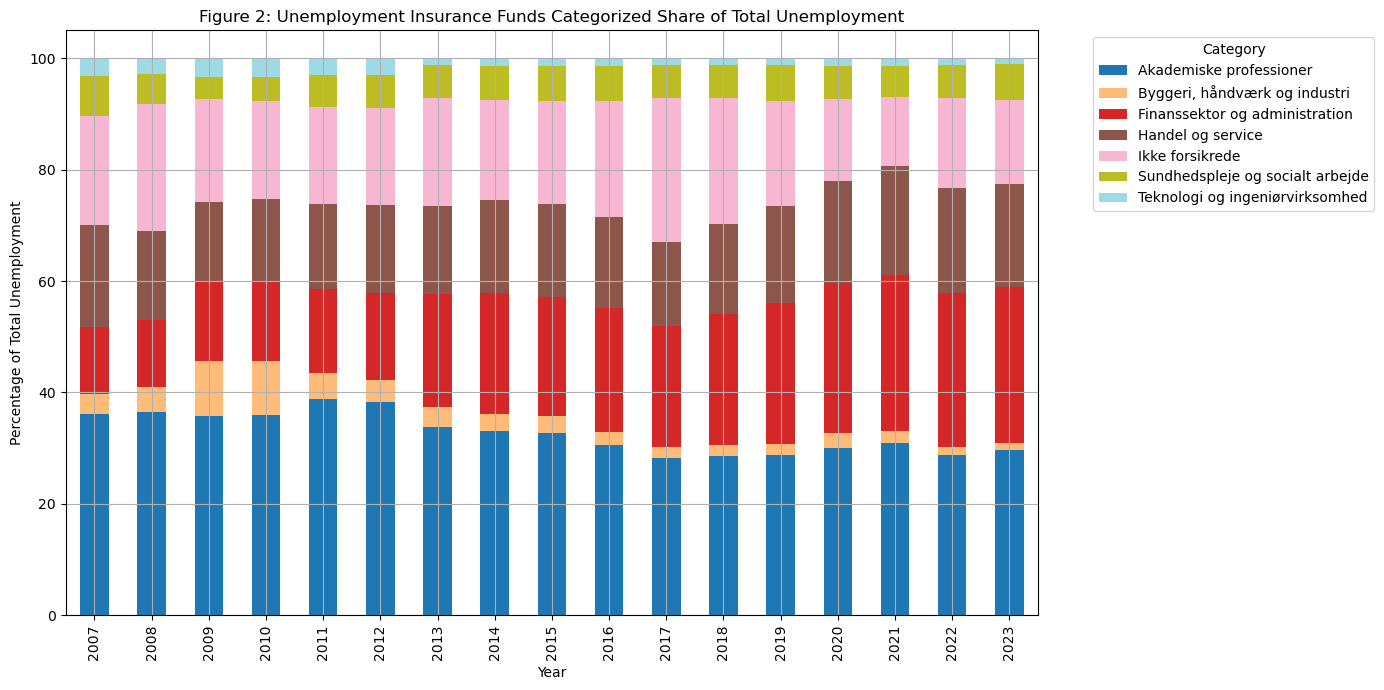

In [38]:
# We start by grouping by 'TID' and 'Category' and calculating the sum of 'Share in pct.'
grouped = unemp_data.groupby(['TID', 'Category'])['Share in pct.'].sum().unstack().fillna(0)

# Create a stacked bar plot
grouped.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='tab20')

# Add gridlines, titles, legend, and axis labels
plt.grid(True)
plt.title('Figure 2: Unemployment Insurance Funds Categorized Share of Total Unemployment')
plt.xlabel('Year')
plt.ylabel('Percentage of Total Unemployment')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

From figure 2 it is important to note, that the share in pct. is calculated by number of people and not the uneployment rate. This means that the graph is influenced of how many people there are in each unemployment incurance funds. But figure 2 shows that the over the whole period 'Akademiske professioner' has been the group of uneployment incuarance funds with the biggest share of total unemployment. But the share has been decreasing from around 36% to around 29%. We can conclude that the biggest rise in share of total unemployment has come from 'Finanssektor og administration'. From this graph it is unclear if it has happened due to more members in this group, or because this group actually got a bigger share of total unemployment compared to the other groups. Throughout the whole period 'Ikke forsikrede' has been the most volatile.  

We now want to make a figure with a dropdown menu, to show each unemployment insurance funds share in pct. of the total unemployment and the real amount of unemployed in each unemplyment insurance fund. 

In [39]:
# To start of we define a list of the unique values in 'AKASSE'
akasse_list = unemp_data['AKASSE'].unique()

# We then define a function that takes an argument 'akasse' and plots the graph
def plot_graph(akasse):
    df = unemp_data[unemp_data['AKASSE'] == akasse]
    fig, ax1 = plt.subplots(figsize=(10,6))
    
    #We costumize the graph with labels and colors
    color = 'tab:blue'
    ax1.set_xlabel('Year')  
    ax1.set_ylabel('Amount', color=color) 
    ax1.plot(df['TID'], df['INDHOLD'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True)  

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Share in pct.', color=color)  
    ax2.plot(df['TID'], df['Share in pct.'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  
    plt.title(f'{akasse}')  
    plt.show()

# We now make a dropdown menu for the 'AKASSE' values that inserts the argumnet 'akasse' in plot_graph
interact(plot_graph, akasse=akasse_list)

interactive(children=(Dropdown(description='akasse', options=('Akademikere (AAK) (- juni 2013)', 'Blik- og rør…

<function __main__.plot_graph(akasse)>

# Conclusion

From our analysis we can conclude the following: Througout the whole period the unemployment insurance fund group with the highest share is 'Akademiske professioner'. An explanation to this could be, that this group is just the group with the higehst amount of members. Never the less, this group has seen a decrease in share of total unemployment over the period. The group with the lowest share of unemployment throughout the whole period is 'Teknologi og enginørvirksomhed', and this group has also seen a decrease in share over the period. Throughout the whole period the unemployment insurance fund with the highest amount of unemployment is 3F. But it is worth to mention that both the amount of people in the fund and its' share of total unemployment has decreased from 2007 to 2022. The fact that this unemployment insurance fund has had the highest share thoughout the whole period could quite well be becuase it is simply the biggest fund in Denmark. 